In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import gc
import copy

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Extract data and Divide into train/test

Here, we will extract all the information regarding train and test data

In [2]:
file_path = "C:\\UMD\\Sem 2\\MSML605 Computing Systems\\Homeworks\\Project\\CUB_200_2011"

images = pd.read_csv(f"{file_path}\\images.txt", 
                     sep=' ', 
                     names=['image_id', 'image_name'])
train_test = pd.read_csv(f"{file_path}\\train_test_split.txt", 
                     sep=' ', 
                     names=['image_id', 'is_training_image'])
classes = pd.read_csv(f"{file_path}\\classes.txt", 
                     sep=' ', 
                     names=['class_id', 'class_name'])
image_class_labels = pd.read_csv(f"{file_path}\\image_class_labels.txt", 
                     sep=' ', 
                     names=['image_id', 'class_id'])

bounding_boxes = pd.read_csv(f'{file_path}\\bounding_boxes.txt',
                             sep=' ',
                             names=['image_id', 'x', 'y', 'width', 'height'])
bounding_boxes = bounding_boxes.astype(int)
#Merging the information given
image_data = images.merge(train_test, on='image_id', how='inner')

labels_data = classes.merge(image_class_labels, on='class_id', how='inner')

image_data = image_data.merge(labels_data, on='image_id', how='inner')

image_data = image_data.merge(bounding_boxes, on='image_id', how='inner')
image_data

,image_id,image_name,is_training_image,class_id,class_name,x,y,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,60,27,325,304
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,139,30,153,264
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,14,112,388,186
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,112,90,255,242
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,70,50,134,303
...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,89,95,354,250
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,157,62,184,219
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,190,102,198,202
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,3,20,408,307


Now, we divide into train and test data using the information given

In [3]:
# Set the first 24 training values in each group to 0 
grouped = image_data[image_data['is_training_image'] == 1].groupby('class_name')
validation_indices = []

for name, group in grouped: 
    validation_indices.extend(group.index[24:])

# Set the first 24 values in each group to 0
image_data['is_validation_image'] = 0
image_data.loc[validation_indices, 'is_validation_image'] = 1
image_data['is_validation_image'].value_counts()

is_validation_image
0    10594
1     1194
Name: count, dtype: int64

In [4]:
#Split the data into training and test
train_indices = (image_data['is_training_image'] == 1) & (image_data['is_validation_image'] == 0)
training_data = image_data[train_indices].reset_index()
validation_data = image_data[image_data['is_validation_image'] == 1].reset_index()
test_data = image_data[image_data['is_training_image'] == 0].reset_index()

#Setting three sets of images: training, validation, and test
X_temp_train = []
X_temp_validation = []
X_temp_test = []
temp = [X_temp_train, X_temp_validation, X_temp_test]

for p, dataframe in enumerate([training_data, validation_data, test_data]):
    #Get the paths for the images
    paths = 'CUB_200_2011/images/' + np.array(dataframe['image_name'])
    
    #Get the image arrays
    for i, img in tqdm.tqdm(enumerate(paths), total=dataframe.shape[0]):
        image = cv2.imread(img)
        x, y, width, height = dataframe.loc[i, ['x', 'y', 'width', 'height']]
        temp[p].append(image[y:y+height, x:x+width, :])
    
len(X_temp_train), len(X_temp_validation), len(X_temp_test)

100%|██████████| 5794/5794 [00:22<00:00, 260.96it/s]


(4800, 1194, 5794)

# Data Preprocessing

Padding all to square and then reshaping all to 224x224

In [5]:
def convert_to_PIL(image):
    return Image.fromarray(image)

# Define the transformation pipeline
transform = transforms.Compose([
    convert_to_PIL,
    # transforms.Resize(256),  # Resize the shorter side to 256, preserving aspect ratio
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


final_image_size = (224, 224)


In [6]:
X_train, X_validation, X_test = [], [], []
for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
    X_train.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_validation), total=len(X_temp_validation)):
    X_validation.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_test), total=len(X_temp_test)):
    X_test.append(transform(img))

100%|██████████| 5794/5794 [00:17<00:00, 324.59it/s]


In [7]:
y_train = np.array(image_data[train_indices]['class_id']) - 1

In [8]:
# train_transform = transforms.Compose([
#     convert_to_PIL,
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomErasing(inplace=True),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
#     X_train.append(train_transform(img))

# y_train = np.array(image_data[train_indices]['class_id']) - 1
# y_train = np.concatenate([y_train, y_train])

In [9]:
# Convert the list of tensors to a 4D tensor (N, H, W, C)
X_train = torch.stack(X_train)   
print("Train done")

X_validation = torch.stack(X_validation) 
print("Validation done")

X_test = torch.stack(X_test)
print("Test done")   

print(X_train.shape, X_validation.shape, X_test.shape)

Train done
Validation done
Test done
torch.Size([4800, 3, 224, 224]) torch.Size([1194, 3, 224, 224]) torch.Size([5794, 3, 224, 224])


Setting labels

In [10]:
# Set the labels for training, validation and test
# y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_test = np.array(image_data[image_data['is_training_image'] == 0]['class_id']) - 1

# dtype=torch.float, torch.long
y_train = torch.Tensor(y_train)
y_validation = torch.Tensor(y_validation).long()
y_test = torch.Tensor(y_test).long()
len(y_train), len(y_validation), len(y_test)

(4800, 1194, 5794)

Creating DataLoader

In [11]:
TrainDataset = data.TensorDataset(X_train, y_train)
ValidationDataset = data.TensorDataset(X_validation, y_validation)
TestDataset = data.TensorDataset(X_test, y_test)

batch_size = 1
TrainLoader = data.DataLoader(dataset=TrainDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

ValidationLoader = data.DataLoader(dataset=ValidationDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

TestLoader = data.DataLoader(dataset=TestDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

len(TrainDataset), len(ValidationDataset), len(TestDataset)

(4800, 1194, 5794)

In [12]:
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


GroundTruth:  17.0


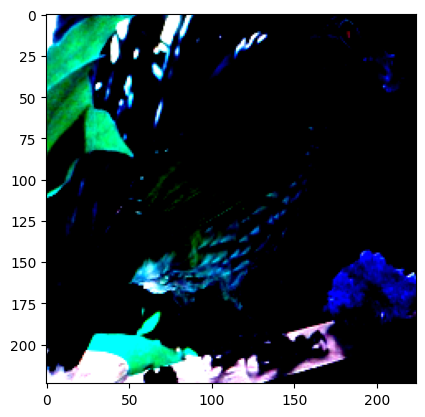

In [14]:
dataiter = iter(TrainLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images, nrow=10).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(1)))

Calculating accuracy function

In [16]:
def calculate_accuracy(model, loader, data_type='training'):
    model.eval() # Set model to evaluation mode

    correct = total = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            #For training, there will be onehot vector, so convert from onehot
            if data_type == 'training': 
                _, labels = torch.max(labels.data, 1)
            
            #Compare with ground truth
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} {data_type} images: {100 * correct / total}')
    return 100 * correct/total
    


# Feature Extraction

In [17]:
models.densenet161()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
# Load the pretrained Densenet 161 model
NewModel = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)


# Modify the final fully connected layers
num_classes = 200  # Replace with the number of bird species

# Redefine the fc layers
# NewModel.classifier = nn.Linear(NewModel.classifier.in_features, num_classes)
NewModel.classifier = nn.Identity()

# Unfreeze all layers 
for param in NewModel.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()


NewModel.to(device)


c:\UMD\.venv\Lib\site-packages\torch\nn\modules\module.py:1159: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [19]:
TrainFeatures = []
ValidationFeatures = []
TestFeatures = []

TrainLabels = []
ValidationLabels = []
TestLabels = []

def get_features(model, loader, features, classified_labels):
    model.eval() # Set model to evaluation mode

    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            features.extend(outputs.cpu())
            classified_labels.extend(labels.cpu())
    return features, classified_labels

TrainFeatures, TrainLabels = get_features(NewModel, TrainLoader, 
                                          TrainFeatures, TrainLabels)
ValidationFeatures, ValidationLabels = get_features(NewModel, ValidationLoader, 
                                                    ValidationFeatures, ValidationLabels)
TestFeatures, TestLabels = get_features(NewModel, TestLoader, 
                                        TestFeatures, TestLabels)


100%|██████████| 5794/5794 [02:34<00:00, 37.42it/s]


In [20]:
TrainFeatures = torch.stack(TrainFeatures)
ValidationFeatures = torch.stack(ValidationFeatures)
TestFeatures = torch.stack(TestFeatures)

TrainLabels = torch.stack(TrainLabels)
ValidationLabels = torch.stack(ValidationLabels)
TestLabels = torch.stack(TestLabels)

TrainFeatures.shape, ValidationFeatures.shape, TestFeatures.shape

(torch.Size([4800, 2208]), torch.Size([1194, 2208]), torch.Size([5794, 2208]))

In [21]:
TrainFeatureDataset = torch.utils.data.TensorDataset(TrainFeatures, TrainLabels)
ValidationFeatureDataset = torch.utils.data.TensorDataset(ValidationFeatures, ValidationLabels)
TestFeatureDataset = torch.utils.data.TensorDataset(TestFeatures, TestLabels)

batch_size = 128
TrainFeatureLoader = torch.utils.data.DataLoader(dataset=TrainFeatureDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
ValidationFeatureLoader = torch.utils.data.DataLoader(dataset=ValidationFeatureDataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4, pin_memory=True)
TestFeatureLoader = torch.utils.data.DataLoader(dataset=TestFeatureDataset, batch_size=batch_size,
                                 shuffle=True, num_workers=4, pin_memory=True)

len(TrainFeatureDataset), len(ValidationFeatureDataset), len(TestFeatureDataset), \
len(TrainFeatureLoader), len(ValidationFeatureLoader), len(TestFeatureLoader)

(4800, 1194, 5794, 38, 10, 46)

# Model

In [22]:
class NeuralNetwork1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork1D, self).__init__()
        self.linear1 = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear1(x)
        return out

In [23]:
model_1d = NeuralNetwork1D(2208, 200)
model_1d.to(device)

NeuralNetwork1D(
  (linear1): Linear(in_features=2208, out_features=200, bias=True)
)

## Check Initial Loss

log(C) for softmax for C classes

In [24]:
def calculate_loss(model, loader, criterion):
    model.eval() # Set model to evaluation mode

    running_loss = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

    return running_loss / len(loader)

calculate_loss(model_1d, TrainFeatureLoader, criterion)


100%|██████████| 38/38 [00:03<00:00, 10.68it/s]


5.357101616106536

In [25]:
- np.log(1/200)

5.298317366548036

We can observe that the loss is nearly as expected. This means that our model is not making any mistake.

The loss should be $log(C)$ where $C$ is the number of classes.

The reason is that the cross entropy is defined as 
$$\frac{1}{N}\sum_{i = 1}^{N}-y_i log(p_i)$$ 
where $y_i = 1$ for correct $i$ and the probability $p_i = \frac{1}{C}$

## Overfit a small sample

We need to get 100% training accuracy on a small sample of training data (5 - 10 minibatches). No weight initialization and regularization.

Bad initialization conditions
- If loss is not going down, LR is too low 
- If loss explodes to `np.inf` or `NaN`, LR is too high

In [26]:
def overfit_model(NewModel, Loader, optimizer, criterion, num_epochs=30):
    training_loss = []
    training_accuracy = []

    for epoch in range(num_epochs):
        NewModel.train()

        running_loss = 0    
        for input_data, labels in tqdm.tqdm(Loader, total=len(Loader)):
            # Forward pass
            labels, input_data = labels.to(device), input_data.to(device)
            output = NewModel(input_data)
            
            # Compute loss
            loss = criterion(output, labels.long())
            running_loss += loss.item()
            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        training_loss.append(running_loss / len(Loader))
        training_accuracy.append(calculate_accuracy(NewModel, Loader, data_type='train'))
    
    return training_loss, training_accuracy

def plot_training_plots(training_loss, training_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].plot(range(len(training_loss)), training_loss)
    ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    ax[1].grid()
    ax[0].grid()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

100%|██████████| 38/38 [00:02<00:00, 12.73it/s]


Epoch [1/10], Loss: 4.0189


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 31.625


100%|██████████| 38/38 [00:02<00:00, 14.83it/s]


Epoch [2/10], Loss: 2.9566


100%|██████████| 38/38 [00:02<00:00, 14.97it/s]


Accuracy of the network on the 38 train images: 62.145833333333336


100%|██████████| 38/38 [00:02<00:00, 14.65it/s]


Epoch [3/10], Loss: 2.4113


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Accuracy of the network on the 38 train images: 74.70833333333333


100%|██████████| 38/38 [00:02<00:00, 14.84it/s]


Epoch [4/10], Loss: 1.9404


100%|██████████| 38/38 [00:02<00:00, 14.78it/s]


Accuracy of the network on the 38 train images: 81.97916666666667


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Epoch [5/10], Loss: 1.5695


100%|██████████| 38/38 [00:02<00:00, 14.90it/s]


Accuracy of the network on the 38 train images: 86.95833333333333


100%|██████████| 38/38 [00:02<00:00, 14.77it/s]


Epoch [6/10], Loss: 1.2525


100%|██████████| 38/38 [00:02<00:00, 15.45it/s]


Accuracy of the network on the 38 train images: 89.54166666666667


100%|██████████| 38/38 [00:02<00:00, 14.76it/s]


Epoch [7/10], Loss: 0.9178


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Accuracy of the network on the 38 train images: 93.10416666666667


100%|██████████| 38/38 [00:02<00:00, 15.21it/s]


Epoch [8/10], Loss: 0.8328


100%|██████████| 38/38 [00:02<00:00, 15.80it/s]


Accuracy of the network on the 38 train images: 94.625


100%|██████████| 38/38 [00:02<00:00, 15.67it/s]


Epoch [9/10], Loss: 0.6607


100%|██████████| 38/38 [00:02<00:00, 15.87it/s]


Accuracy of the network on the 38 train images: 96.33333333333333


100%|██████████| 38/38 [00:02<00:00, 15.17it/s]


Epoch [10/10], Loss: 0.6458


100%|██████████| 38/38 [00:02<00:00, 15.58it/s]

Accuracy of the network on the 38 train images: 96.58333333333333


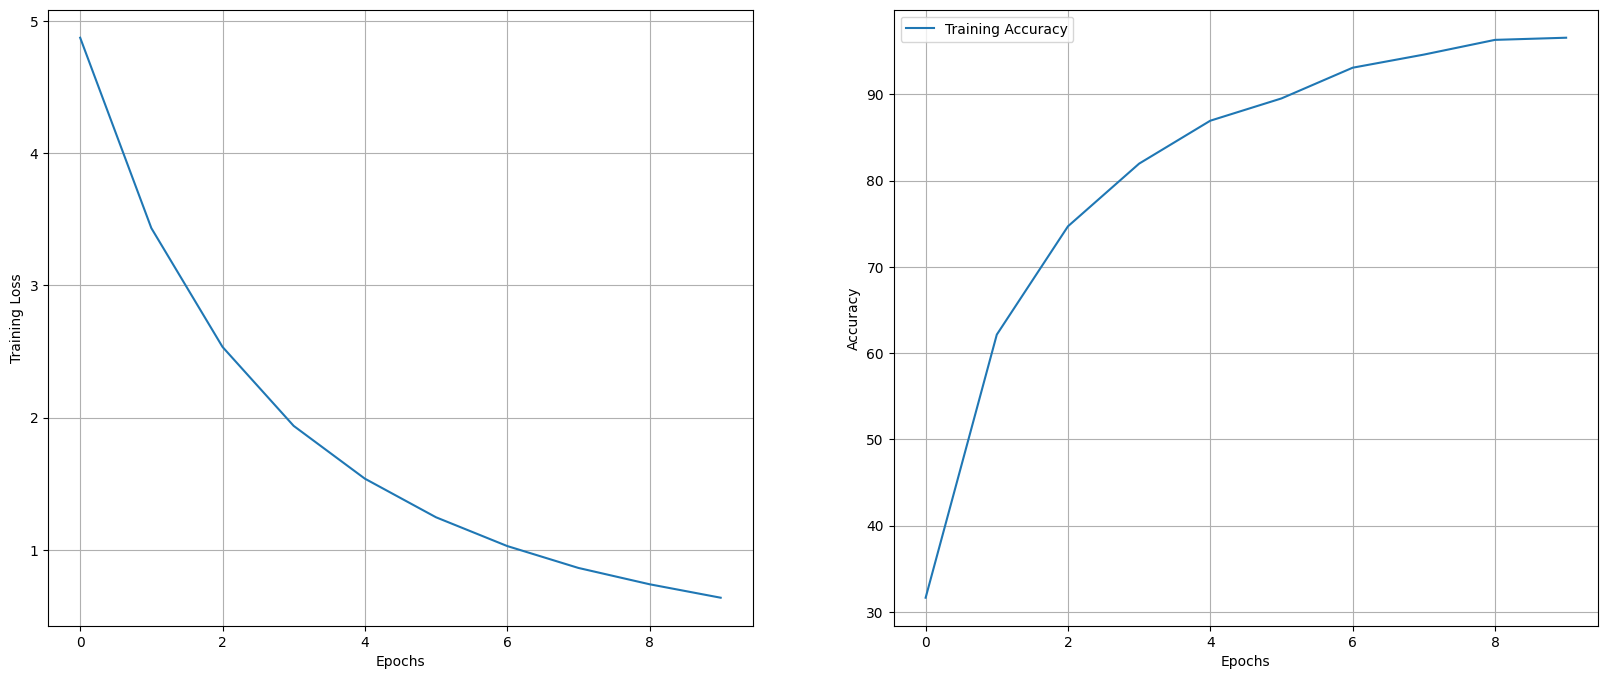

In [32]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)

optimizer = optim.Adam(params=checkModel.parameters(), lr=0.001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adam_training_loss, adam_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(adam_training_loss, adam_training_accuracy)

We can observe that Adam optimizer can overfit a sample with the given optimizers.

100%|██████████| 38/38 [00:02<00:00, 15.58it/s]


Epoch [1/10], Loss: 5.2653


100%|██████████| 38/38 [00:02<00:00, 15.53it/s]


Accuracy of the network on the 38 train images: 0.8333333333333334


100%|██████████| 38/38 [00:02<00:00, 15.55it/s]


Epoch [2/10], Loss: 5.3389


100%|██████████| 38/38 [00:02<00:00, 15.50it/s]


Accuracy of the network on the 38 train images: 0.9166666666666666


100%|██████████| 38/38 [00:02<00:00, 15.50it/s]


Epoch [3/10], Loss: 5.2767


100%|██████████| 38/38 [00:02<00:00, 15.84it/s]


Accuracy of the network on the 38 train images: 1.0416666666666667


100%|██████████| 38/38 [00:02<00:00, 15.81it/s]


Epoch [4/10], Loss: 5.3334


100%|██████████| 38/38 [00:02<00:00, 15.88it/s]


Accuracy of the network on the 38 train images: 1.2916666666666667


100%|██████████| 38/38 [00:02<00:00, 15.66it/s]


Epoch [5/10], Loss: 5.2122


100%|██████████| 38/38 [00:02<00:00, 15.69it/s]


Accuracy of the network on the 38 train images: 1.3958333333333333


100%|██████████| 38/38 [00:02<00:00, 15.11it/s]


Epoch [6/10], Loss: 5.2426


100%|██████████| 38/38 [00:02<00:00, 15.74it/s]


Accuracy of the network on the 38 train images: 1.7291666666666667


100%|██████████| 38/38 [00:02<00:00, 15.39it/s]


Epoch [7/10], Loss: 5.1934


100%|██████████| 38/38 [00:02<00:00, 15.65it/s]


Accuracy of the network on the 38 train images: 1.8958333333333333


100%|██████████| 38/38 [00:02<00:00, 15.46it/s]


Epoch [8/10], Loss: 5.2256


100%|██████████| 38/38 [00:02<00:00, 15.83it/s]


Accuracy of the network on the 38 train images: 2.25


100%|██████████| 38/38 [00:02<00:00, 15.47it/s]


Epoch [9/10], Loss: 5.1694


100%|██████████| 38/38 [00:02<00:00, 15.76it/s]


Accuracy of the network on the 38 train images: 2.6666666666666665


100%|██████████| 38/38 [00:02<00:00, 15.39it/s]


Epoch [10/10], Loss: 5.1639


100%|██████████| 38/38 [00:02<00:00, 15.83it/s]

Accuracy of the network on the 38 train images: 3.0625


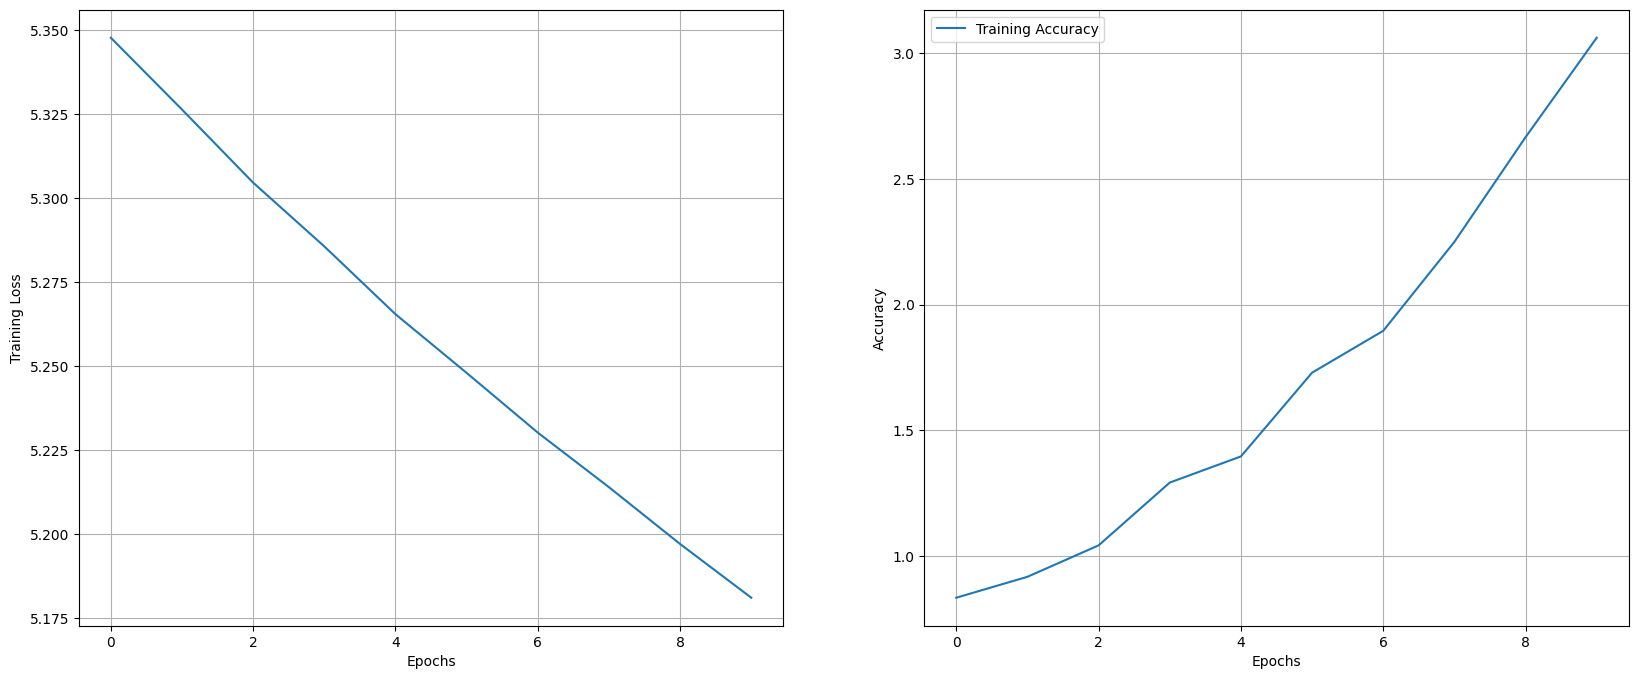

In [33]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

sgd_training_loss, sgd_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=sgd_training_loss, training_accuracy=sgd_training_accuracy)

100%|██████████| 38/38 [00:02<00:00, 15.21it/s]


Epoch [1/10], Loss: 5.3025


100%|██████████| 38/38 [00:02<00:00, 15.54it/s]


Accuracy of the network on the 38 train images: 2.0625


100%|██████████| 38/38 [00:02<00:00, 14.30it/s]


Epoch [2/10], Loss: 5.1024


100%|██████████| 38/38 [00:02<00:00, 15.53it/s]


Accuracy of the network on the 38 train images: 7.1875


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Epoch [3/10], Loss: 4.9453


100%|██████████| 38/38 [00:02<00:00, 15.75it/s]


Accuracy of the network on the 38 train images: 14.708333333333334


100%|██████████| 38/38 [00:02<00:00, 15.29it/s]


Epoch [4/10], Loss: 4.7698


100%|██████████| 38/38 [00:02<00:00, 15.48it/s]


Accuracy of the network on the 38 train images: 21.416666666666668


100%|██████████| 38/38 [00:02<00:00, 15.24it/s]


Epoch [5/10], Loss: 4.6589


100%|██████████| 38/38 [00:02<00:00, 15.75it/s]


Accuracy of the network on the 38 train images: 28.8125


100%|██████████| 38/38 [00:02<00:00, 15.08it/s]


Epoch [6/10], Loss: 4.5543


100%|██████████| 38/38 [00:02<00:00, 15.64it/s]


Accuracy of the network on the 38 train images: 33.833333333333336


100%|██████████| 38/38 [00:02<00:00, 15.31it/s]


Epoch [7/10], Loss: 4.4194


100%|██████████| 38/38 [00:02<00:00, 15.24it/s]


Accuracy of the network on the 38 train images: 40.5625


100%|██████████| 38/38 [00:02<00:00, 15.64it/s]


Epoch [8/10], Loss: 4.3480


100%|██████████| 38/38 [00:02<00:00, 15.91it/s]


Accuracy of the network on the 38 train images: 45.791666666666664


100%|██████████| 38/38 [00:02<00:00, 15.32it/s]


Epoch [9/10], Loss: 4.1718


100%|██████████| 38/38 [00:02<00:00, 15.73it/s]


Accuracy of the network on the 38 train images: 50.25


100%|██████████| 38/38 [00:02<00:00, 15.35it/s]


Epoch [10/10], Loss: 4.0742


100%|██████████| 38/38 [00:02<00:00, 15.59it/s]

Accuracy of the network on the 38 train images: 54.145833333333336


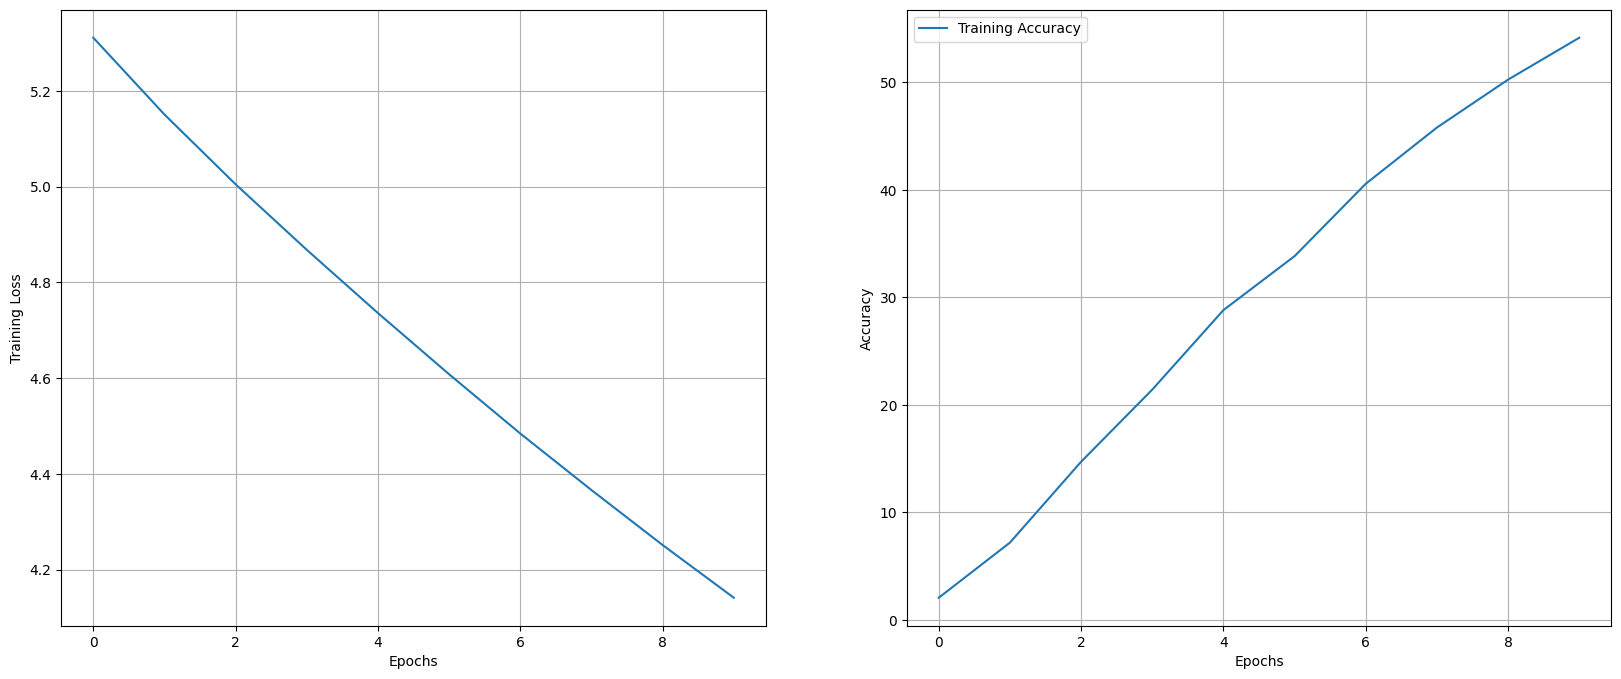

In [34]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0, momentum=0.9)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

msgd_training_loss, msgd_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=msgd_training_loss, training_accuracy=msgd_training_accuracy)

100%|██████████| 38/38 [00:02<00:00, 14.84it/s]


Epoch [1/10], Loss: 4.2722


100%|██████████| 38/38 [00:02<00:00, 15.49it/s]


Accuracy of the network on the 38 train images: 35.541666666666664


100%|██████████| 38/38 [00:02<00:00, 15.36it/s]


Epoch [2/10], Loss: 2.9088


100%|██████████| 38/38 [00:02<00:00, 15.63it/s]


Accuracy of the network on the 38 train images: 63.666666666666664


100%|██████████| 38/38 [00:02<00:00, 14.89it/s]


Epoch [3/10], Loss: 2.5859


100%|██████████| 38/38 [00:02<00:00, 15.16it/s]


Accuracy of the network on the 38 train images: 76.35416666666667


100%|██████████| 38/38 [00:02<00:00, 15.31it/s]


Epoch [4/10], Loss: 1.7764


100%|██████████| 38/38 [00:02<00:00, 15.60it/s]


Accuracy of the network on the 38 train images: 83.0


100%|██████████| 38/38 [00:02<00:00, 15.28it/s]


Epoch [5/10], Loss: 1.5716


100%|██████████| 38/38 [00:02<00:00, 15.47it/s]


Accuracy of the network on the 38 train images: 87.8125


100%|██████████| 38/38 [00:02<00:00, 15.37it/s]


Epoch [6/10], Loss: 1.2127


100%|██████████| 38/38 [00:02<00:00, 15.41it/s]


Accuracy of the network on the 38 train images: 90.5625


100%|██████████| 38/38 [00:02<00:00, 15.43it/s]


Epoch [7/10], Loss: 0.7894


100%|██████████| 38/38 [00:02<00:00, 15.55it/s]


Accuracy of the network on the 38 train images: 92.08333333333333


100%|██████████| 38/38 [00:02<00:00, 15.17it/s]


Epoch [8/10], Loss: 0.9283


100%|██████████| 38/38 [00:02<00:00, 16.03it/s]


Accuracy of the network on the 38 train images: 94.72916666666667


100%|██████████| 38/38 [00:02<00:00, 15.54it/s]


Epoch [9/10], Loss: 0.6250


100%|██████████| 38/38 [00:02<00:00, 15.29it/s]


Accuracy of the network on the 38 train images: 95.70833333333333


100%|██████████| 38/38 [00:02<00:00, 13.90it/s]


Epoch [10/10], Loss: 0.5054


100%|██████████| 38/38 [00:02<00:00, 14.82it/s]

Accuracy of the network on the 38 train images: 96.39583333333333


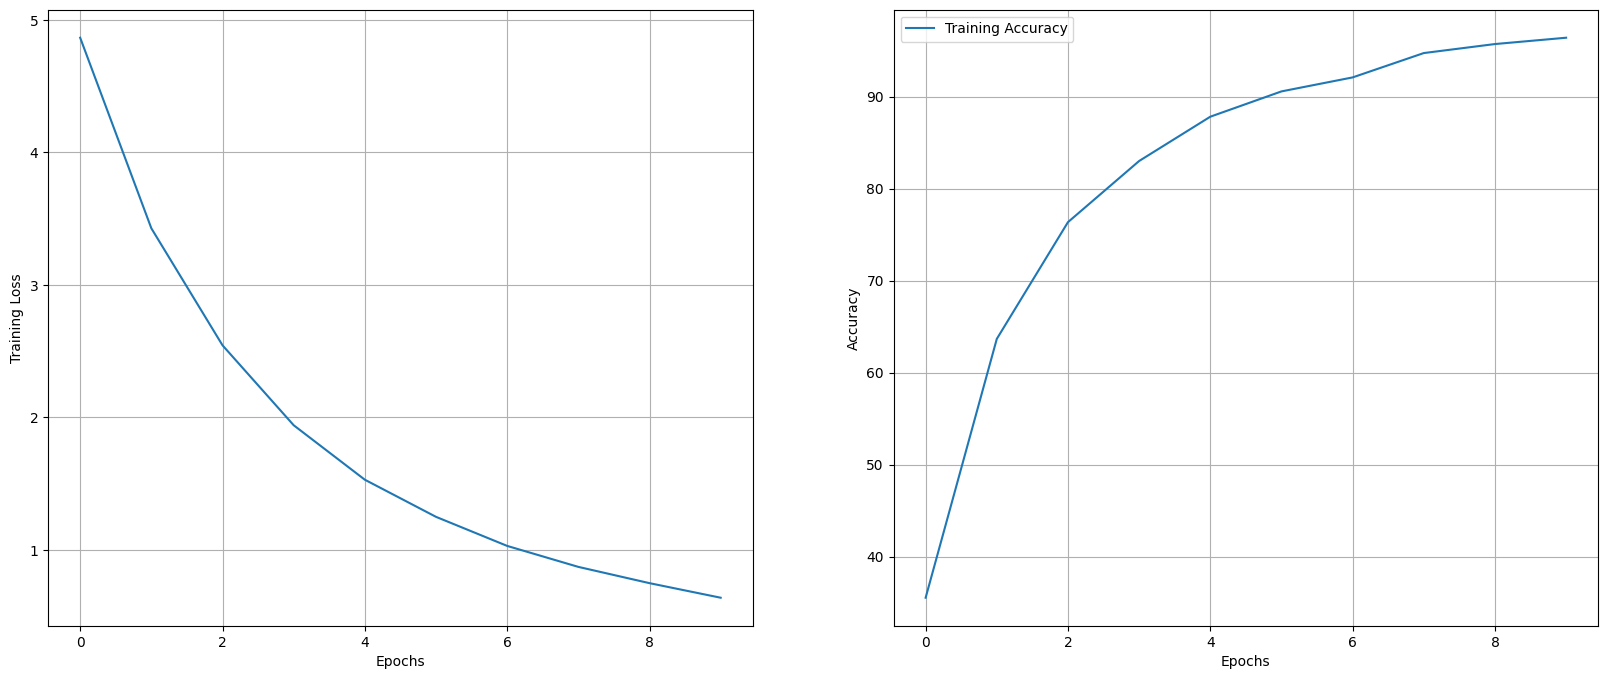

In [35]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.AdamW(params=checkModel.parameters(), lr=0.001)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adamW_training_loss, adamW_training_accuracy = overfit_model(checkModel, TrainFeatureLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=adamW_training_loss, training_accuracy=adamW_training_accuracy)

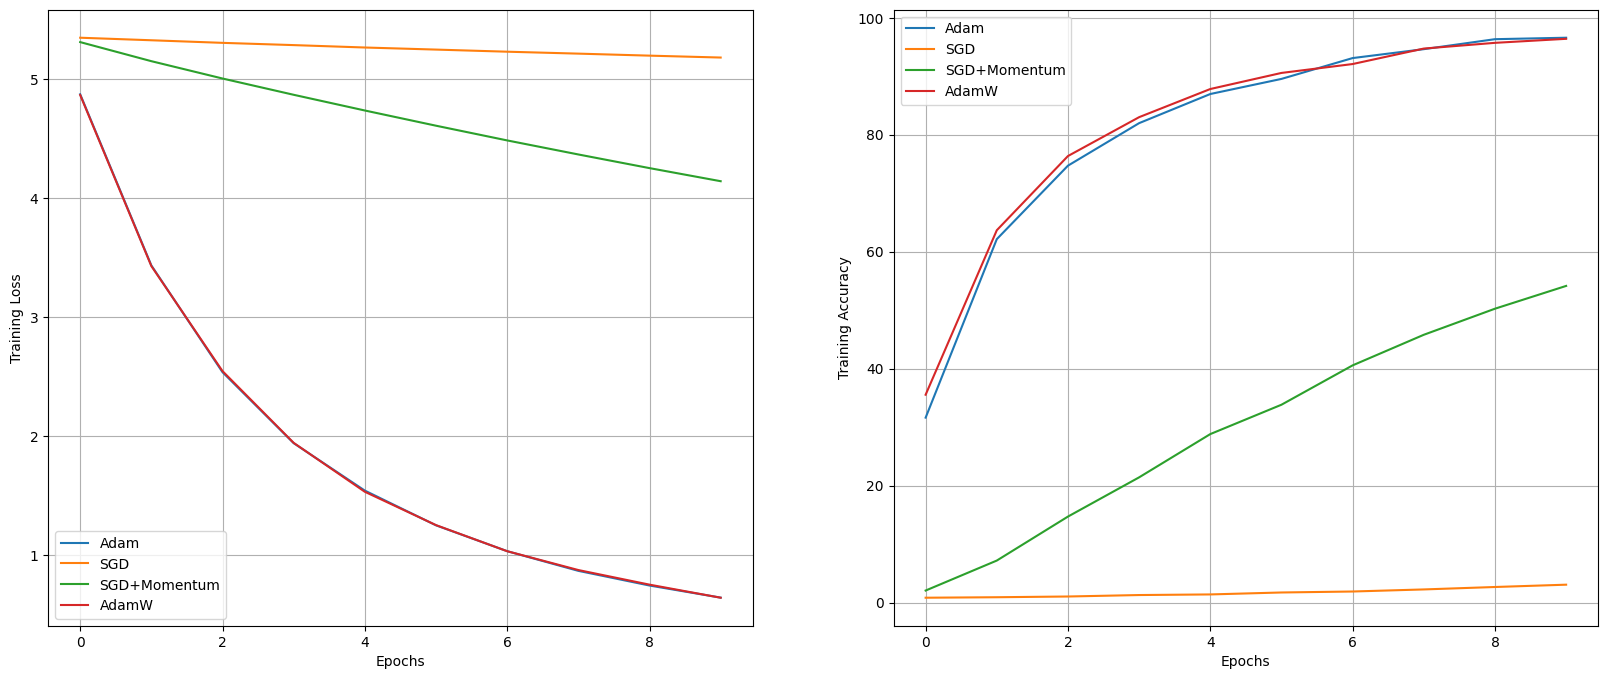

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(adam_training_loss)), adam_training_loss, label='Adam')
ax[0].plot(range(len(sgd_training_loss)), sgd_training_loss, label='SGD')
ax[0].plot(range(len(msgd_training_loss)), msgd_training_loss, label='SGD+Momentum')
ax[0].plot(range(len(adamW_training_loss)), adamW_training_loss, label='AdamW')

ax[1].plot(range(len(adam_training_accuracy)), adam_training_accuracy, label='Adam')
ax[1].plot(range(len(sgd_training_accuracy)), sgd_training_accuracy, label='SGD')
ax[1].plot(range(len(msgd_training_accuracy)), msgd_training_accuracy, label='SGD+Momentum')
ax[1].plot(range(len(adamW_training_accuracy)), adamW_training_accuracy, label='AdamW')

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')

plt.show()

## Find Learning Rate that makes loss go down

Use the architecture from the previous step and use all training data, turn on small weight decay, find learning rate that makes the loss drop significantly (within 100 iterations)

Good learning rates: 1e-1, 1e-2, 1e-3, 1e-4

0.1


100%|██████████| 38/38 [00:03<00:00, 10.80it/s]


Epoch [1/5], Loss: 231.8027


100%|██████████| 38/38 [00:02<00:00, 15.01it/s]


Accuracy of the network on the 38 train images: 6.270833333333333


100%|██████████| 38/38 [00:02<00:00, 14.82it/s]


Epoch [2/5], Loss: 70.0592


100%|██████████| 38/38 [00:02<00:00, 15.37it/s]


Accuracy of the network on the 38 train images: 38.875


100%|██████████| 38/38 [00:02<00:00, 15.12it/s]


Epoch [3/5], Loss: 7.5522


100%|██████████| 38/38 [00:02<00:00, 14.81it/s]


Accuracy of the network on the 38 train images: 68.83333333333333


100%|██████████| 38/38 [00:02<00:00, 14.59it/s]


Epoch [4/5], Loss: 7.1580


100%|██████████| 38/38 [00:02<00:00, 14.64it/s]


Accuracy of the network on the 38 train images: 77.16666666666667


100%|██████████| 38/38 [00:02<00:00, 14.92it/s]


Epoch [5/5], Loss: 2.6334


100%|██████████| 38/38 [00:02<00:00, 15.21it/s]


Accuracy of the network on the 38 train images: 89.375
0.01


100%|██████████| 38/38 [00:02<00:00, 15.12it/s]


Epoch [1/5], Loss: 3.0798


100%|██████████| 38/38 [00:02<00:00, 15.15it/s]


Accuracy of the network on the 38 train images: 52.541666666666664


100%|██████████| 38/38 [00:02<00:00, 15.23it/s]


Epoch [2/5], Loss: 1.4783


100%|██████████| 38/38 [00:02<00:00, 15.33it/s]


Accuracy of the network on the 38 train images: 79.45833333333333


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Epoch [3/5], Loss: 0.6549


100%|██████████| 38/38 [00:02<00:00, 14.93it/s]


Accuracy of the network on the 38 train images: 90.20833333333333


100%|██████████| 38/38 [00:02<00:00, 14.83it/s]


Epoch [4/5], Loss: 0.2798


100%|██████████| 38/38 [00:02<00:00, 15.44it/s]


Accuracy of the network on the 38 train images: 94.66666666666667


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Epoch [5/5], Loss: 0.1633


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 98.10416666666667
0.001


100%|██████████| 38/38 [00:02<00:00, 14.91it/s]


Epoch [1/5], Loss: 4.2156


100%|██████████| 38/38 [00:02<00:00, 15.21it/s]


Accuracy of the network on the 38 train images: 35.854166666666664


100%|██████████| 38/38 [00:02<00:00, 14.67it/s]


Epoch [2/5], Loss: 3.0974


100%|██████████| 38/38 [00:02<00:00, 15.53it/s]


Accuracy of the network on the 38 train images: 62.520833333333336


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Epoch [3/5], Loss: 2.2365


100%|██████████| 38/38 [00:02<00:00, 14.41it/s]


Accuracy of the network on the 38 train images: 72.91666666666667


100%|██████████| 38/38 [00:02<00:00, 13.81it/s]


Epoch [4/5], Loss: 1.8685


100%|██████████| 38/38 [00:02<00:00, 14.22it/s]


Accuracy of the network on the 38 train images: 82.4375


100%|██████████| 38/38 [00:02<00:00, 13.97it/s]


Epoch [5/5], Loss: 1.4638


100%|██████████| 38/38 [00:02<00:00, 14.33it/s]


Accuracy of the network on the 38 train images: 87.91666666666667
0.0001


100%|██████████| 38/38 [00:02<00:00, 13.74it/s]


Epoch [1/5], Loss: 5.1686


100%|██████████| 38/38 [00:02<00:00, 14.73it/s]


Accuracy of the network on the 38 train images: 4.479166666666667


100%|██████████| 38/38 [00:02<00:00, 14.30it/s]


Epoch [2/5], Loss: 5.0439


100%|██████████| 38/38 [00:02<00:00, 14.07it/s]


Accuracy of the network on the 38 train images: 13.416666666666666


100%|██████████| 38/38 [00:02<00:00, 12.76it/s]


Epoch [3/5], Loss: 4.8074


100%|██████████| 38/38 [00:02<00:00, 14.24it/s]


Accuracy of the network on the 38 train images: 23.6875


100%|██████████| 38/38 [00:02<00:00, 13.77it/s]


Epoch [4/5], Loss: 4.6182


100%|██████████| 38/38 [00:02<00:00, 13.91it/s]


Accuracy of the network on the 38 train images: 35.145833333333336


100%|██████████| 38/38 [00:02<00:00, 13.70it/s]


Epoch [5/5], Loss: 4.4879


100%|██████████| 38/38 [00:02<00:00, 14.45it/s]


Accuracy of the network on the 38 train images: 44.25
1e-05


100%|██████████| 38/38 [00:02<00:00, 13.97it/s]


Epoch [1/5], Loss: 5.3063


100%|██████████| 38/38 [00:02<00:00, 14.10it/s]


Accuracy of the network on the 38 train images: 0.8541666666666666


100%|██████████| 38/38 [00:02<00:00, 13.49it/s]


Epoch [2/5], Loss: 5.3150


100%|██████████| 38/38 [00:02<00:00, 14.66it/s]


Accuracy of the network on the 38 train images: 1.0208333333333333


100%|██████████| 38/38 [00:02<00:00, 14.09it/s]


Epoch [3/5], Loss: 5.2297


100%|██████████| 38/38 [00:02<00:00, 13.93it/s]


Accuracy of the network on the 38 train images: 1.2083333333333333


100%|██████████| 38/38 [00:02<00:00, 13.56it/s]


Epoch [4/5], Loss: 5.1926


100%|██████████| 38/38 [00:02<00:00, 15.25it/s]


Accuracy of the network on the 38 train images: 1.3541666666666667


100%|██████████| 38/38 [00:02<00:00, 15.19it/s]


Epoch [5/5], Loss: 5.1916


100%|██████████| 38/38 [00:02<00:00, 15.69it/s]

Accuracy of the network on the 38 train images: 1.7083333333333333


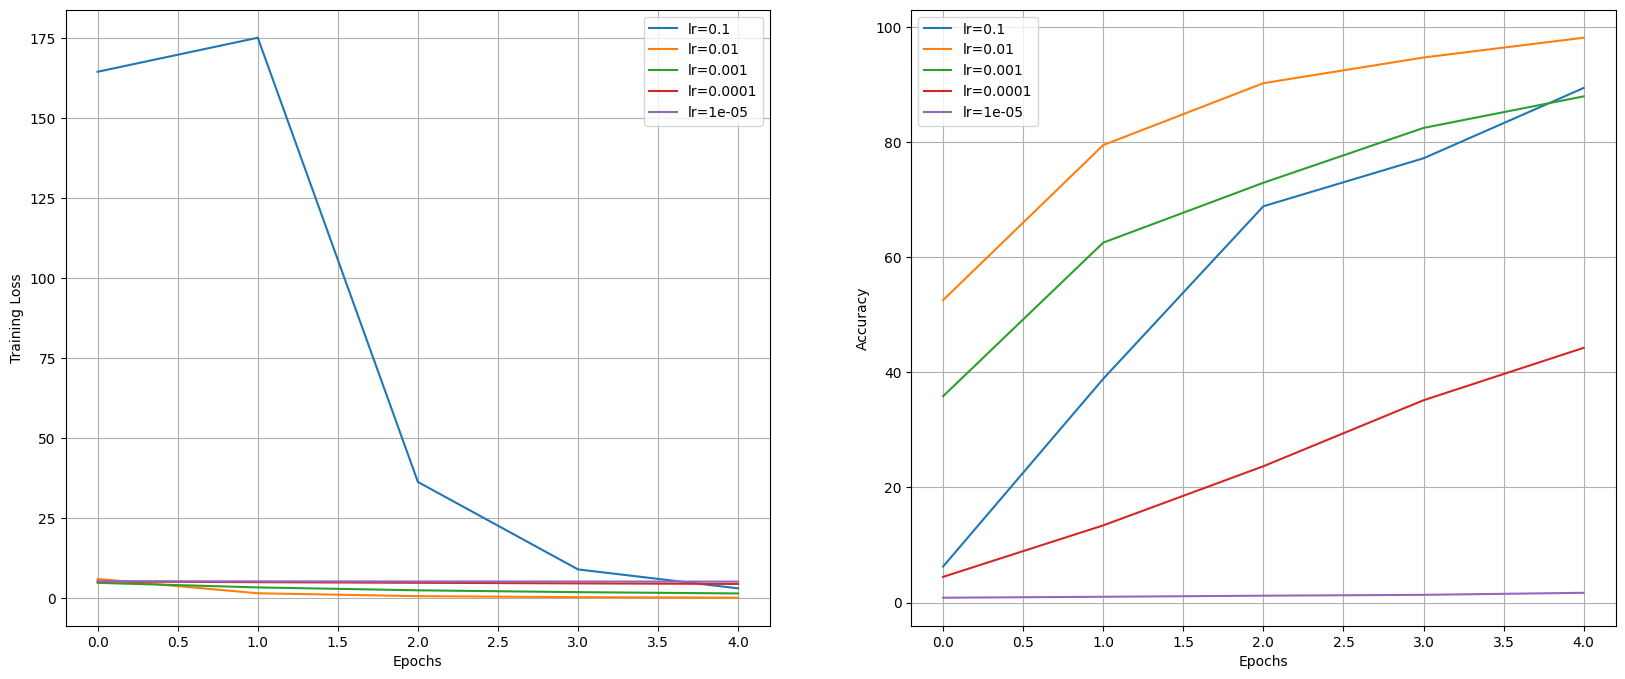

In [37]:
adamW_lr_loss, adamW_lr_accuracy = [], []
lr_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_rates:
    print(lr)
    checkModel = copy.deepcopy(model_1d)
    checkModel.to(device)

    optimizer = optim.AdamW(params=checkModel.parameters(), lr=lr, weight_decay=0.0001)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainFeatureLoader, 
                                                        optimizer, criterion, num_epochs=5)

    adamW_lr_loss.append(training_loss)
    adamW_lr_accuracy.append(training_accuracy)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adamW_lr_loss[i])), adamW_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adamW_lr_accuracy[i])), adamW_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Coarse grid (train for 1-5 epochs)

Choose a few values of learning rate and weight decay around what worked on step 3, tain a few models for 1-5 epochs

Good weight decay to try: 1e-4, 1e-5, 0

In [38]:
adamW_lr_wd_loss, adamW_lr_wd_accuracy = [], []
# lr_rates = np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)
# lr_rates = [1e-2, 1e-3, 1e-4, 1e-5]
weight_decay = np.array([0, 1e-4, 1e-5])
lr = 1e-2
for wd in weight_decay:
    print(f"lr={lr}, wd={wd}")
    checkModel = copy.deepcopy(model_1d)
    checkModel.to(device)

    optimizer = optim.AdamW(params=checkModel.parameters(), lr=lr, weight_decay=wd)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainFeatureLoader, 
                                                        optimizer, criterion, num_epochs=5)

    adamW_lr_wd_loss.append(training_loss)
    adamW_lr_wd_accuracy.append(training_accuracy)
    print()


lr=0.01, wd=0.0


100%|██████████| 38/38 [00:02<00:00, 15.43it/s]


Epoch [1/5], Loss: 3.3045


100%|██████████| 38/38 [00:02<00:00, 15.47it/s]


Accuracy of the network on the 38 train images: 56.395833333333336


100%|██████████| 38/38 [00:02<00:00, 15.35it/s]


Epoch [2/5], Loss: 0.8988


100%|██████████| 38/38 [00:02<00:00, 15.18it/s]


Accuracy of the network on the 38 train images: 80.22916666666667


100%|██████████| 38/38 [00:02<00:00, 14.71it/s]


Epoch [3/5], Loss: 0.6030


100%|██████████| 38/38 [00:02<00:00, 15.01it/s]


Accuracy of the network on the 38 train images: 93.08333333333333


100%|██████████| 38/38 [00:02<00:00, 15.32it/s]


Epoch [4/5], Loss: 0.5327


100%|██████████| 38/38 [00:02<00:00, 15.65it/s]


Accuracy of the network on the 38 train images: 94.625


100%|██████████| 38/38 [00:02<00:00, 14.66it/s]


Epoch [5/5], Loss: 0.1585


100%|██████████| 38/38 [00:02<00:00, 15.01it/s]


Accuracy of the network on the 38 train images: 98.72916666666667

lr=0.01, wd=0.0001


100%|██████████| 38/38 [00:02<00:00, 13.76it/s]


Epoch [1/5], Loss: 4.0559


100%|██████████| 38/38 [00:02<00:00, 14.48it/s]


Accuracy of the network on the 38 train images: 49.083333333333336


100%|██████████| 38/38 [00:02<00:00, 14.92it/s]


Epoch [2/5], Loss: 0.9792


100%|██████████| 38/38 [00:02<00:00, 15.28it/s]


Accuracy of the network on the 38 train images: 78.41666666666667


100%|██████████| 38/38 [00:02<00:00, 15.28it/s]


Epoch [3/5], Loss: 0.9891


100%|██████████| 38/38 [00:02<00:00, 15.88it/s]


Accuracy of the network on the 38 train images: 91.0


100%|██████████| 38/38 [00:02<00:00, 15.49it/s]


Epoch [4/5], Loss: 0.2074


100%|██████████| 38/38 [00:02<00:00, 15.42it/s]


Accuracy of the network on the 38 train images: 96.33333333333333


100%|██████████| 38/38 [00:02<00:00, 15.28it/s]


Epoch [5/5], Loss: 0.3165


100%|██████████| 38/38 [00:02<00:00, 15.19it/s]


Accuracy of the network on the 38 train images: 98.66666666666667

lr=0.01, wd=1e-05


100%|██████████| 38/38 [00:02<00:00, 15.05it/s]


Epoch [1/5], Loss: 3.1302


100%|██████████| 38/38 [00:02<00:00, 15.12it/s]


Accuracy of the network on the 38 train images: 51.75


100%|██████████| 38/38 [00:02<00:00, 15.12it/s]


Epoch [2/5], Loss: 1.3669


100%|██████████| 38/38 [00:02<00:00, 15.55it/s]


Accuracy of the network on the 38 train images: 79.875


100%|██████████| 38/38 [00:02<00:00, 15.03it/s]


Epoch [3/5], Loss: 0.6115


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Accuracy of the network on the 38 train images: 92.85416666666667


100%|██████████| 38/38 [00:02<00:00, 14.88it/s]


Epoch [4/5], Loss: 0.3443


100%|██████████| 38/38 [00:02<00:00, 14.85it/s]


Accuracy of the network on the 38 train images: 95.60416666666667


100%|██████████| 38/38 [00:02<00:00, 14.68it/s]


Epoch [5/5], Loss: 0.2228


100%|██████████| 38/38 [00:02<00:00, 15.61it/s]

Accuracy of the network on the 38 train images: 98.20833333333333



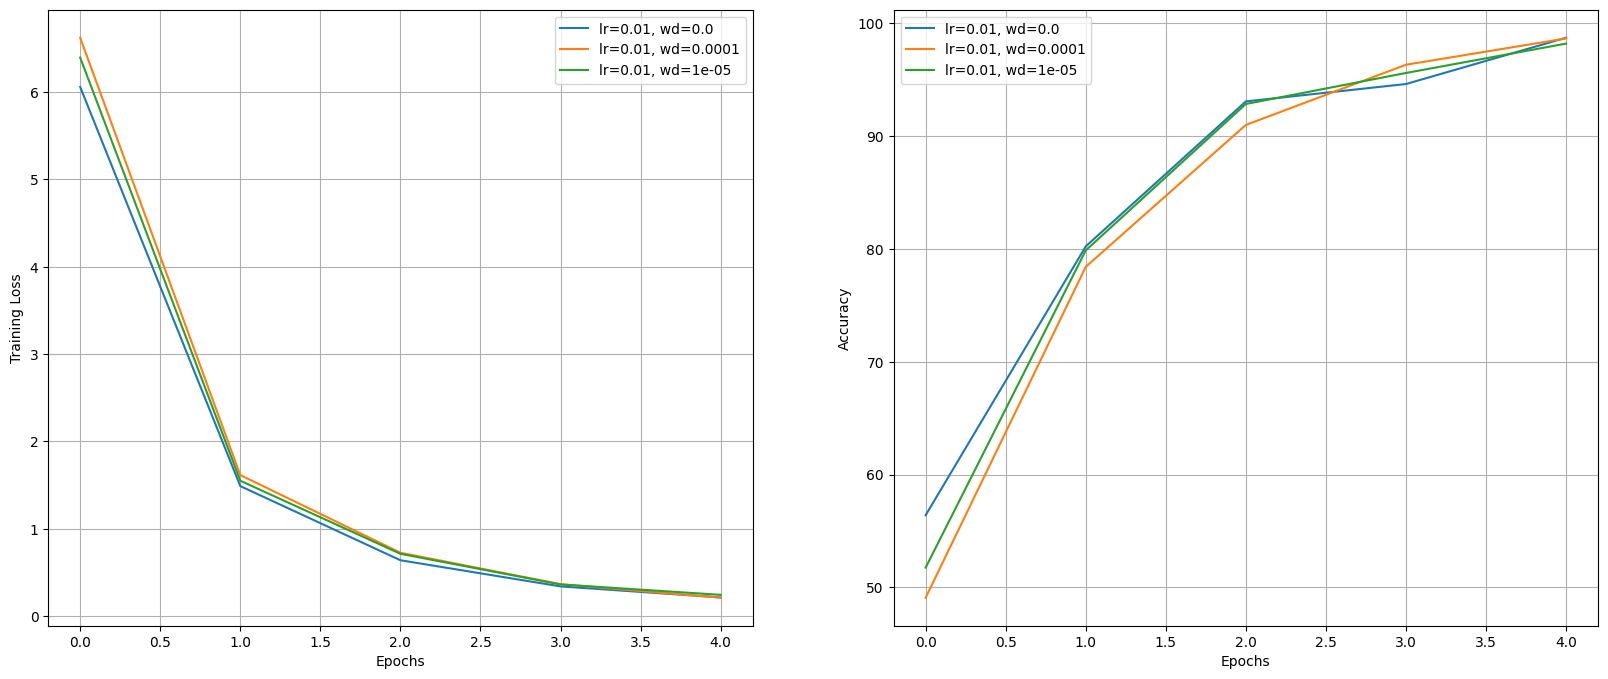

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

for j in range(len(weight_decay)):
    ax[0].plot(range(len(adamW_lr_wd_loss[j])), 
                adamW_lr_wd_loss[j], 
                label=f"lr={lr}, wd={weight_decay[j]}")
    
    ax[1].plot(range(len(adamW_lr_wd_accuracy[j])), 
                adamW_lr_wd_accuracy[j], 
                label=f"lr={lr}, wd={weight_decay[j]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Refine grid, train longer

Pick best models from coarse grid, train them for longer (~10-20 epochs) without learning decay.

Check for
- Loss curves bad initialization:
    - if there is a plateau at the initial stage of the curve.
    - if there is a plateau at the end of the curve (implying the need for learning decay).
- Train and Validation accuracy curves:
    - Overfitting
    - Underfitting

# Training
There is a small error while printing loss. I printed final batch's loss after an epoch instead of whole batches' loss.

In [40]:
checkModel = copy.deepcopy(model_1d)
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 40

optimizer = optim.AdamW(params=checkModel.parameters(), lr=1e-2, weight_decay=0)

for epoch in range(num_epochs):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainFeatureLoader, total=len(TrainFeatureLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    training_loss.append(running_loss / len(TrainFeatureLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainFeatureLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationFeatureLoader, data_type='validation'))
    

    # if (epoch + 1) % 10 == 0:
    #     fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    #     ax[0].plot(range(len(training_loss)), training_loss)
    #     ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    #     ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
    #     ax[1].grid()
    #     ax[0].grid()
    #     ax[0].set_xlabel('Epochs')
    #     ax[0].set_ylabel('Training Loss')
    #     ax[1].set_xlabel('Epochs')
    #     ax[1].set_ylabel('Accuracy')
    #     ax[1].legend()
    #     plt.show()
        # torch.save(checkModel.state_dict(), f"checkModel_{epoch}.pth")
calculate_accuracy(checkModel, TestFeatureLoader, data_type='test')

100%|██████████| 38/38 [00:03<00:00, 11.42it/s]


Epoch [1/40], Loss: 3.4012


100%|██████████| 38/38 [00:02<00:00, 14.84it/s]


Accuracy of the network on the 38 train images: 56.375


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Accuracy of the network on the 10 validation images: 39.36348408710218


100%|██████████| 38/38 [00:02<00:00, 14.96it/s]


Epoch [2/40], Loss: 1.5401


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Accuracy of the network on the 38 train images: 82.85416666666667


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Accuracy of the network on the 10 validation images: 52.428810720268004


100%|██████████| 38/38 [00:02<00:00, 15.16it/s]


Epoch [3/40], Loss: 0.7490


100%|██████████| 38/38 [00:02<00:00, 14.88it/s]


Accuracy of the network on the 38 train images: 91.4375


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Accuracy of the network on the 10 validation images: 56.867671691792296


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Epoch [4/40], Loss: 0.3385


100%|██████████| 38/38 [00:02<00:00, 15.31it/s]


Accuracy of the network on the 38 train images: 95.25


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


Accuracy of the network on the 10 validation images: 61.222780569514235


100%|██████████| 38/38 [00:02<00:00, 14.14it/s]


Epoch [5/40], Loss: 0.1428


100%|██████████| 38/38 [00:02<00:00, 14.09it/s]


Accuracy of the network on the 38 train images: 97.83333333333333


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Accuracy of the network on the 10 validation images: 62.47906197654942


100%|██████████| 38/38 [00:02<00:00, 13.87it/s]


Epoch [6/40], Loss: 0.1065


100%|██████████| 38/38 [00:02<00:00, 14.03it/s]


Accuracy of the network on the 38 train images: 99.125


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Accuracy of the network on the 10 validation images: 64.65661641541038


100%|██████████| 38/38 [00:02<00:00, 13.35it/s]


Epoch [7/40], Loss: 0.0447


100%|██████████| 38/38 [00:02<00:00, 13.83it/s]


Accuracy of the network on the 38 train images: 99.54166666666667


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Accuracy of the network on the 10 validation images: 67.08542713567839


100%|██████████| 38/38 [00:02<00:00, 13.96it/s]


Epoch [8/40], Loss: 0.0497


100%|██████████| 38/38 [00:02<00:00, 14.00it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 10 validation images: 68.25795644891122


100%|██████████| 38/38 [00:02<00:00, 13.79it/s]


Epoch [9/40], Loss: 0.0253


100%|██████████| 38/38 [00:02<00:00, 14.37it/s]


Accuracy of the network on the 38 train images: 99.95833333333333


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Accuracy of the network on the 10 validation images: 68.09045226130654


100%|██████████| 38/38 [00:02<00:00, 14.03it/s]


Epoch [10/40], Loss: 0.0275


100%|██████████| 38/38 [00:02<00:00, 14.35it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Accuracy of the network on the 10 validation images: 68.5929648241206


100%|██████████| 38/38 [00:02<00:00, 13.78it/s]


Epoch [11/40], Loss: 0.0175


100%|██████████| 38/38 [00:02<00:00, 13.75it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


Accuracy of the network on the 10 validation images: 69.09547738693468


100%|██████████| 38/38 [00:02<00:00, 13.91it/s]


Epoch [12/40], Loss: 0.0158


100%|██████████| 38/38 [00:02<00:00, 14.22it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Accuracy of the network on the 10 validation images: 69.09547738693468


100%|██████████| 38/38 [00:02<00:00, 14.41it/s]


Epoch [13/40], Loss: 0.0144


100%|██████████| 38/38 [00:02<00:00, 14.43it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Accuracy of the network on the 10 validation images: 69.76549413735343


100%|██████████| 38/38 [00:02<00:00, 13.32it/s]


Epoch [14/40], Loss: 0.0132


100%|██████████| 38/38 [00:02<00:00, 15.70it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


Accuracy of the network on the 10 validation images: 68.76046901172529


100%|██████████| 38/38 [00:02<00:00, 15.30it/s]


Epoch [15/40], Loss: 0.0155


100%|██████████| 38/38 [00:02<00:00, 15.72it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


Accuracy of the network on the 10 validation images: 69.01172529313233


100%|██████████| 38/38 [00:02<00:00, 15.44it/s]


Epoch [16/40], Loss: 0.0117


100%|██████████| 38/38 [00:02<00:00, 15.41it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Accuracy of the network on the 10 validation images: 68.67671691792295


100%|██████████| 38/38 [00:02<00:00, 15.09it/s]


Epoch [17/40], Loss: 0.0082


100%|██████████| 38/38 [00:02<00:00, 15.87it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


Accuracy of the network on the 10 validation images: 69.17922948073702


100%|██████████| 38/38 [00:02<00:00, 14.93it/s]


Epoch [18/40], Loss: 0.0092


100%|██████████| 38/38 [00:02<00:00, 15.31it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


Accuracy of the network on the 10 validation images: 69.09547738693468


100%|██████████| 38/38 [00:02<00:00, 14.58it/s]


Epoch [19/40], Loss: 0.0084


100%|██████████| 38/38 [00:02<00:00, 15.67it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


Accuracy of the network on the 10 validation images: 69.43048576214406


100%|██████████| 38/38 [00:02<00:00, 15.16it/s]


Epoch [20/40], Loss: 0.0079


100%|██████████| 38/38 [00:02<00:00, 15.81it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Accuracy of the network on the 10 validation images: 68.84422110552764


100%|██████████| 38/38 [00:02<00:00, 15.26it/s]


Epoch [21/40], Loss: 0.0088


100%|██████████| 38/38 [00:02<00:00, 15.64it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


Accuracy of the network on the 10 validation images: 69.26298157453937


100%|██████████| 38/38 [00:02<00:00, 15.27it/s]


Epoch [22/40], Loss: 0.0065


100%|██████████| 38/38 [00:02<00:00, 15.21it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


Accuracy of the network on the 10 validation images: 68.67671691792295


100%|██████████| 38/38 [00:02<00:00, 13.74it/s]


Epoch [23/40], Loss: 0.0062


100%|██████████| 38/38 [00:02<00:00, 15.73it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


Accuracy of the network on the 10 validation images: 69.43048576214406


100%|██████████| 38/38 [00:02<00:00, 15.61it/s]


Epoch [24/40], Loss: 0.0068


100%|██████████| 38/38 [00:02<00:00, 15.65it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


Accuracy of the network on the 10 validation images: 69.76549413735343


100%|██████████| 38/38 [00:02<00:00, 15.20it/s]


Epoch [25/40], Loss: 0.0053


100%|██████████| 38/38 [00:02<00:00, 15.46it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Accuracy of the network on the 10 validation images: 69.01172529313233


100%|██████████| 38/38 [00:02<00:00, 15.36it/s]


Epoch [26/40], Loss: 0.0052


100%|██████████| 38/38 [00:02<00:00, 15.77it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Accuracy of the network on the 10 validation images: 69.5142378559464


100%|██████████| 38/38 [00:02<00:00, 15.52it/s]


Epoch [27/40], Loss: 0.0054


100%|██████████| 38/38 [00:02<00:00, 15.53it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


Accuracy of the network on the 10 validation images: 69.26298157453937


100%|██████████| 38/38 [00:02<00:00, 15.54it/s]


Epoch [28/40], Loss: 0.0049


100%|██████████| 38/38 [00:02<00:00, 15.80it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


Accuracy of the network on the 10 validation images: 69.59798994974874


100%|██████████| 38/38 [00:02<00:00, 15.38it/s]


Epoch [29/40], Loss: 0.0051


100%|██████████| 38/38 [00:02<00:00, 15.81it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


Accuracy of the network on the 10 validation images: 69.26298157453937


100%|██████████| 38/38 [00:02<00:00, 15.35it/s]


Epoch [30/40], Loss: 0.0056


100%|██████████| 38/38 [00:02<00:00, 15.41it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.17it/s]


Accuracy of the network on the 10 validation images: 69.01172529313233


100%|██████████| 38/38 [00:02<00:00, 15.36it/s]


Epoch [31/40], Loss: 0.0045


100%|██████████| 38/38 [00:02<00:00, 15.69it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Accuracy of the network on the 10 validation images: 69.01172529313233


100%|██████████| 38/38 [00:02<00:00, 15.25it/s]


Epoch [32/40], Loss: 0.0046


100%|██████████| 38/38 [00:02<00:00, 15.11it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Accuracy of the network on the 10 validation images: 68.50921273031825


100%|██████████| 38/38 [00:02<00:00, 15.50it/s]


Epoch [33/40], Loss: 0.0042


100%|██████████| 38/38 [00:02<00:00, 15.75it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


Accuracy of the network on the 10 validation images: 69.43048576214406


100%|██████████| 38/38 [00:02<00:00, 15.31it/s]


Epoch [34/40], Loss: 0.0042


100%|██████████| 38/38 [00:02<00:00, 15.64it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Accuracy of the network on the 10 validation images: 69.26298157453937


100%|██████████| 38/38 [00:02<00:00, 15.22it/s]


Epoch [35/40], Loss: 0.0039


100%|██████████| 38/38 [00:02<00:00, 15.63it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.27it/s]


Accuracy of the network on the 10 validation images: 69.84924623115577


100%|██████████| 38/38 [00:02<00:00, 15.11it/s]


Epoch [36/40], Loss: 0.0037


100%|██████████| 38/38 [00:02<00:00, 15.54it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Accuracy of the network on the 10 validation images: 68.84422110552764


100%|██████████| 38/38 [00:02<00:00, 15.43it/s]


Epoch [37/40], Loss: 0.0037


100%|██████████| 38/38 [00:02<00:00, 15.36it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Accuracy of the network on the 10 validation images: 69.84924623115577


100%|██████████| 38/38 [00:02<00:00, 14.61it/s]


Epoch [38/40], Loss: 0.0035


100%|██████████| 38/38 [00:02<00:00, 15.06it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Accuracy of the network on the 10 validation images: 69.17922948073702


100%|██████████| 38/38 [00:02<00:00, 15.04it/s]


Epoch [39/40], Loss: 0.0034


100%|██████████| 38/38 [00:02<00:00, 15.10it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Accuracy of the network on the 10 validation images: 69.59798994974874


100%|██████████| 38/38 [00:02<00:00, 14.78it/s]


Epoch [40/40], Loss: 0.0024


100%|██████████| 38/38 [00:02<00:00, 14.60it/s]


Accuracy of the network on the 38 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


Accuracy of the network on the 10 validation images: 69.26298157453937


100%|██████████| 46/46 [00:02<00:00, 17.85it/s]

Accuracy of the network on the 46 test images: 69.39937866758716


69.39937866758716

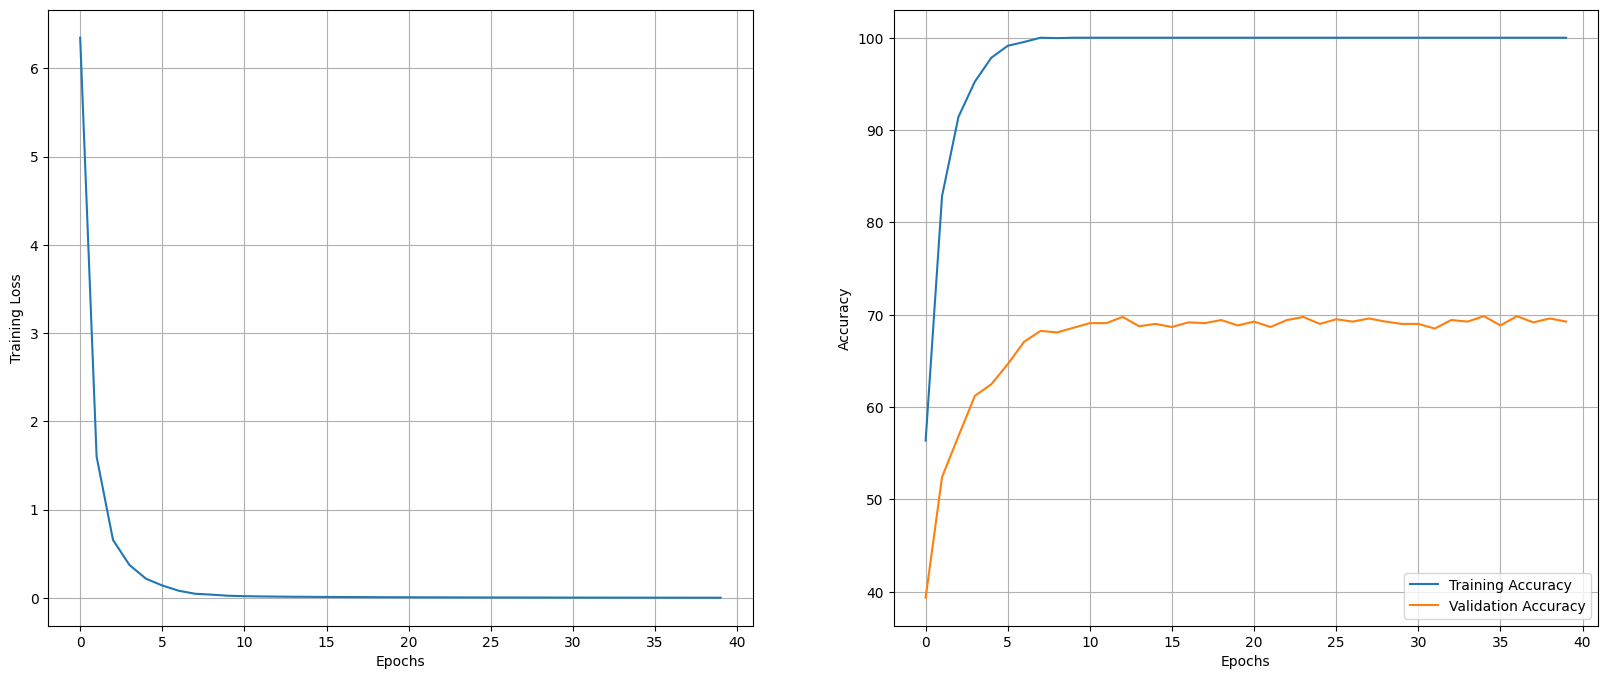

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(training_loss)), training_loss)
ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
ax[1].grid()
ax[0].grid()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()
torch.save(checkModel.state_dict(), f"DenseNet161_FeatureExtraction_1D_AdamW_1e-2_lr_40_epoch.pth")

# Check the downloaded model 

Comparing whether the model developed is working in properly

In [42]:
#Filling all the trained parameters
check_model_1d = NeuralNetwork1D(2208, 200)
load_model = torch.load("DenseNet161_FeatureExtraction_1D_AdamW_1e-2_lr_40_epoch.pth")
check_model_1d.load_state_dict(load_model)
check_model_1d.to(device)

#Imagenet parameters
imgnet_densenet161 = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
imgnet_densenet161.classifier = nn.Identity()

for param in imgnet_densenet161.parameters():
    param.requires_grad = False
imgnet_densenet161.to(device)

#Combining the two models
check_model_1d = nn.Sequential(imgnet_densenet161, check_model_1d)

Check with the test loader whether the accuracy of 69.39% was right

In [43]:
calculate_accuracy(check_model_1d, TestLoader, data_type='test')

100%|██████████| 5794/5794 [02:23<00:00, 40.30it/s]

Accuracy of the network on the 5794 test images: 69.39937866758716


69.39937866758716

Yes, the model is working as it is said

# GRAD CAM

In [44]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

def generate_cam(image, labels, model, target_layers, transform):
    #Display image 
    display_image = image.resize((224, 224))
    required_image = np.array(display_image) / 255

    transformed_image = transform(image)
    model.eval()

    #Grad CAM for each target layer
    images = display_image
    for i, label in enumerate(labels):
        targets = [ClassifierOutputTarget(label)]
        
        cam = GradCAM(model=model, target_layers=target_layers)#, use_cuda=True) 

        gray_cam = cam(input_tensor=transformed_image.unsqueeze(0), targets=targets, aug_smooth=True)

        cam_image = show_cam_on_image(required_image, gray_cam[0, :], use_rgb=True)

        images = np.hstack((images, cam_image))

    return Image.fromarray(images)

In [45]:
#Filling all the trained parameters
test_model_1d = NeuralNetwork1D(2208, 200)
load_model = torch.load("DenseNet161_FeatureExtraction_1D_AdamW_1e-2_lr_40_epoch.pth")
test_model_1d.load_state_dict(load_model)
test_model_1d.to(device)

#Imagenet parameters
test_densenet161 = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
test_densenet161.classifier = nn.Identity()
test_densenet161.to(device)

#Combining the two models
grad_model_1d = nn.Sequential(test_densenet161, test_model_1d)
grad_model_1d.to(device)

Sequential(
  (0): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, 

The images are as follows: Normal resized image to 224x224, CAM for predicted label, CAM for actual label
Predicted: 21, Actual: 21, 
            Predicted probability: 0.9918419122695923


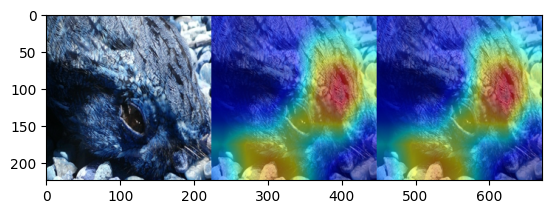

Predicted: 144, Actual: 146, 
            Predicted probability: 0.6677101254463196


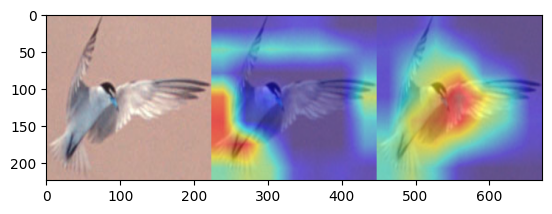

Predicted: 179, Actual: 179, 
            Predicted probability: 0.7834736704826355


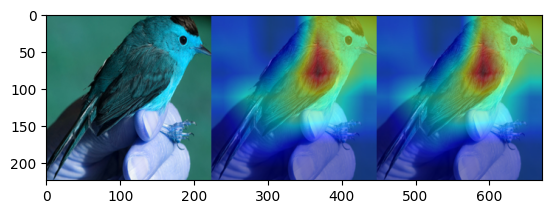

Predicted: 10, Actual: 10, 
            Predicted probability: 0.8850945830345154


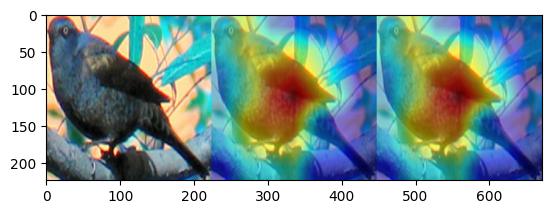

Predicted: 191, Actual: 191, 
            Predicted probability: 0.7982676029205322


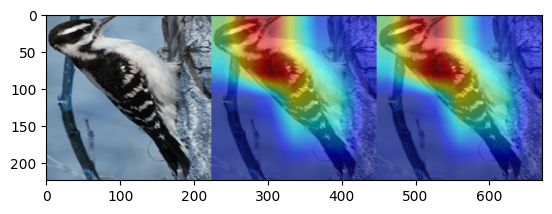

Predicted: 35, Actual: 35, 
            Predicted probability: 0.9866634607315063


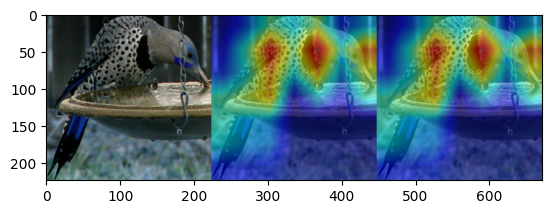

Predicted: 26, Actual: 8, 
            Predicted probability: 0.8448463678359985


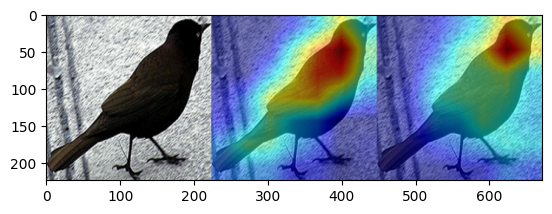

Predicted: 145, Actual: 145, 
            Predicted probability: 0.2973194122314453


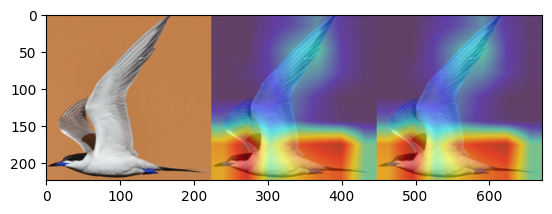

Predicted: 165, Actual: 165, 
            Predicted probability: 0.9582666754722595


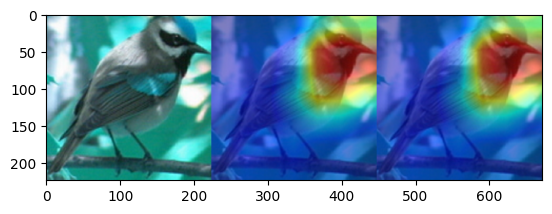

Predicted: 115, Actual: 115, 
            Predicted probability: 0.5490037798881531


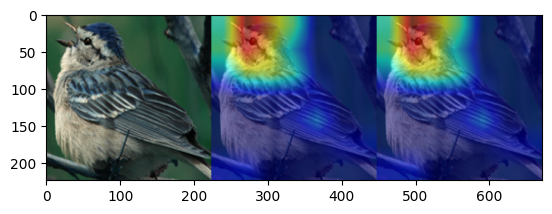

In [47]:
rand_val = np.random.randint(len(X_test), size=10)

print("The images are as follows: Normal resized image to 224x224, CAM for predicted label, CAM for actual label")
for i in rand_val:
    #Get the image and label
    image = Image.fromarray(X_temp_test[i])
    label = y_test[i]
    target_layers = [grad_model_1d[0].features.denseblock4.denselayer24.conv2]
    
    #Transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #Predict the image
    grad_model_1d.eval()
    output = grad_model_1d(transform(image).unsqueeze(0).to(device))
    result = nn.Softmax(dim=1)(output)
    predicted = torch.argmax(output, dim=1).item()
    print(f"""Predicted: {predicted}, Actual: {label.item()}, 
            Predicted probability: {result[0][predicted].item()}""")
    
    #Generate CAM
    cam_image = generate_cam(image, [predicted, label], grad_model_1d, target_layers, transform)
    plt.imshow(cam_image)
    plt.show()

We can observe that the last layer of CAM is most of the time highlighting the bird rather than the background. This implies that the model is good.